# 4 Modelado del conjunto de datos
A lo largo de este notebook se cubre parte de la cuarta fase de la metodología CRIPS-DM, en este caso el desarrollo del modelo final. En este caso, el modelo se trata de un ensemble que combina el mejor predictor, RetinaNet, el mejor segmentador SAM, y la adición de una red variante de la UNET que corrige errores del modelo final.

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo y requisitos del proyecto, traduciendo las necesidades a una definición analítica del problema y una estrategia para abordarlo.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en carga y análisis exploratorio del conjunto de datos.

3. **Preparación de los Datos (Data Preparation)**
   - Consistente en la limpieza, preparación y extracción de características de los datos, de vital importancia para el modelado dado que determinará la calidad de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span>
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, el modelo a emplear se tratará de un ensemble que combina la obtención de detecciones de objetos mediante `RetinaNet`, la obtención de las máscaras mediante `Segment Anything Model` y la corrección de errores de una variante de la `UNET`.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo, determinando si cumple con los requisitos definidos en la primera de las fases y si es factible su implementación.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso, en este caso mediante una aplicación web.

### Implementación

El entrenamiento de este modelo ensemble tipo stacking puede dividirse en dos bloques diferenciados, en primer lugar la pipeline de inferencia preentrenada, cuyos pesos quedan bloqueados y se limitan a generar las predicciones en formato *raw* y en segundo lado el modelo de corrección `UNET`, cuyos pesos serán entrenados desde cero.

Dado que uno de los grandes blottlenecks del entrenamiento del modelo *Baseline* se ha tratado del tiempo de entrenamiento debido a la falta de recursos computacionales, para el entrenamiento del modelo se automatizará la generación del `tf.Dataset` a emplear por el segundo modelo, sin aplicar data augmentation, dado que el tiempo de inferncia medio del modelo es de 30 segundos para su primera fase.




En este caso, al arquitectura de este modelo ensemble es la equivalente a la mostrada en la siguiente imagen:

<img src="./../assets/figs/final_pipeline.png" alt="Problema a resolver" style="width: 50%; height: auto;">



### 1. Pipeline de inferencia del primer bloque

A continuación, se desarrolla la pipeline del primer bloque del modelo y se automatiza su carga en la estuctura de datos elegida


In [ ]:
#import importlib
#import utils
from utils import load_yaml_file
from utils import plot_image_and_mask, mask_generator,plot_bounding_boxes, plot_differences_batch, plot_one_hot_encoded_masks_norm, one_hot_encoder_masks, plot_differences, get_data_id_image

from tqdm import tqdm
import numpy as np
import os
import time
import pandas as pd
import random

#from google.colab import drive

import torch
import keras
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms as T
from IPython.display import clear_output
import tensorflow as tf
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, models
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pycocotools.coco import COCO



Al igual que en el resto de notebooks, se cargan las variables y estructuras de datos necesarias:

In [2]:
yaml = load_yaml_file()
objetives = yaml["objetive_classes"]
N = yaml["size_sample"]

In [3]:

N_CLASSES = len(objetives) + 1 # Se incluye el background que estara en el canal 0

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=35.34s)
creating index...
index created!


In [4]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}

Se definen los thersholds de segmentación y detección para el primer bloque del ensemble:

In [5]:
CONS_TRHESHOLD = 0.3
CONS_THRESHOLD_SEGMENTATION = 0.3

In [6]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)



Se cargan los modelos a emplear en el primer bloque del ensemble, en este caso `RetinaNet` y `SAM`

In [7]:

sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)

In [8]:

retina_model = retinanet_resnet50_fpn(pretrained=True)
retina_model.eval()

c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [ ]:
def get_one_hot_mask(current_scores,mask,categories_names_by_index ):

    one_hot_scores=np.zeros((len(categories_names_by_index),mask.shape[0],mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):
        # print("mask shapes", mask.shape)
        # print("class", clase)
        # print("shapes ", one_hot_scores.shape)
        # print("scores shape ", current_scores.shape)
        one_hot_scores[clase,:,:]=np.where(mask==clase,current_scores,0)

    one_hot_scores[0,:,:]= 1 -one_hot_scores[1:,:,:].sum(axis=0)

    #print("output has shape", one_hot_scores.shape)

    return one_hot_scores

def process_inference_retina_sam(image,retina_model,sam_model,mapper_indexModel_index_result,category_info_objetive):

    # RETINANET INFERENCE
    transform = T.Compose([
        T.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        inference=retina_model(img_tensor)
        inference=inference[0]


    # SAM INFERENCE
    sam_model.set_image(image)
    final_mask=np.zeros(image.shape[:2],dtype=np.int8)
    current_scores=np.zeros(image.shape[:2],dtype=np.float32)

    masks_image=[]
    scores_image=[]
    labels_image=[]
    #category_info_objetive = {v: k for k, v in categories_index_by_name.items()}
    # print(inference)
    # print(f"{inference['boxes']}=")

    flag_found=0

    for box, score, label in zip(inference['boxes'], inference['scores'], inference['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            label=mapper_indexModel_index_result[label.item()]
            masks,scores, _ = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None,:],
                multimask_output=False
            )
            if np.any(masks):
                flag_found = 1
                masks_image.append(masks)
                scores_image.append(scores)
                labels_image.append(label)

                mask_values=np.where(masks, scores, 0)
                final_mask=np.where(mask_values>current_scores,label,final_mask)
                current_scores=np.maximum(mask_values,current_scores)

    # OUTPUT PREPROCESSING
    if(flag_found):
        final_mask=final_mask[0]
    current_scores=current_scores[0]
    #final_mask_one_hot = get_one_hot_mask(current_scores, final_mask,categories_names_by_index )



    return final_mask,final_mask


Se definen los paths en los que se almacenarán las estructuras de datos correspondientes

In [ ]:
tfrecord_path_train = r"C:\Users\ruben\Desktop\code_tfm\src\dataset_train_first_block_final_model.tfrecord"
tfrecord_path_test = r"C:\Users\ruben\Desktop\code_tfm\src\dataset_test_first_block_final_model.tfrecord"

A continuación, se define una función que permita insertar elementos aleatorios en la imagen, con el objetivo de  .Asimismo, se define una funcón que permite recortar máscaras si al colocar estas se salen de los límites de la imagen:

In [ ]:
CONST_THRESHOLD_SIZE_CROPPING = 100

def redimensionar_recorte(img, mask, target_shape):

    input_alt,input_anc, _ =img.shape
    target_alt,target_anc, _ =target_shape

    recorte= img[:min(input_alt,target_alt),:min(input_anc,target_anc),:]
    mascara_recorte=mask[:min(input_alt,target_alt),:min(input_anc,target_anc)]

    padding_top=max(target_alt-recorte.shape[0],0)
    padding_dcha=max(target_anc-recorte.shape[1],0)

    padded = np.pad(recorte,((padding_top, 0),(0,padding_dcha),(0,0)),mode='constant',constant_values=0)
    padded_mascara = np.pad(mascara_recorte,((padding_top,0),(0,padding_dcha)),mode='constant',constant_values=0)

    return padded, padded_mascara

def insertar_mascara_random(img, mask_orig, target_class, target_channel):


    while True:

        img_ids =  coco.getImgIds(catIds=[target_class])
        target_id = random.choice(img_ids)
        target_info  = coco.loadImgs(target_id)[0]
        target_path  = os.path.join(DIR_TRAIN_IMGS,target_info['file_name'])
        target = cv2.imread(target_path)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=target_id,  catIds=[target_class],  iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        ann = random.choice(anns)
        mascara_target = coco.annToMask(ann)


        shape = img.shape
        target, mascara_target = redimensionar_recorte(target,mascara_target,shape)

        if np.sum(mascara_target) > CONST_THRESHOLD_SIZE_CROPPING:
            break

    bool_mascara_3d = mascara_target[:,:,np.newaxis]
    result_imagen = np.where(bool_mascara_3d,target,img)
    mask_orig[mascara_target.astype(bool)] = target_channel


    return result_imagen, mask_orig

Se monta la pipeline que realiza los siguientes pasos:
1) Preprocesamiento de imagen y ground truth, para obtener las imágenes en un tamaño común, en este caso (256, 256) para poder entrenar el segundo bloque.
2) Obtención del cuarto canal de la imagen de entrada para el enternamiento del modelo, correspondiente con la predicción del ensemble del primer bloque, en este caso RetinaNet + SAM.
3) Generación de la salida en un formato adecuado para poder almacenar en la estructura de datos, en este caso `.tfrecord`.

In [ ]:
def serialize_example(img_id,coco,path_images, id_objetives ):

    img, mask = mask_generator(coco,img_id,ids_masks= id_objetives,path_images = path_images)
    #print("masl", np.unique(mask))
    mask=np.vectorize(lambda x:dict_class_index.get(x,x))(mask)
    img = np.array(img)
    for _ in range(4):
        class_cropping=random.choice(id_objetives)
        target_channel=mapper_indexModel_index_result[class_cropping]
        img,mask = insertar_mascara_random(img,mask,class_cropping,target_channel)

    ### INPUT PREPROCESSING  ###
    # print("previsous shape is ", img.shape)
    img = cv2.resize(img,(256,256), interpolation=cv2.INTER_LINEAR)
    # print("now is is ", img.shape)
    mask = cv2.resize(mask,(256,256), interpolation=cv2.INTER_NEAREST)
    img_codificada=tf.io.encode_jpeg(img).numpy()
    mask=mask.astype(np.uint8)
    mask_raw=mask.tobytes()
    mask_shape=list(mask.shape)

    ###   PIPELINE INFERENCE   #####
    pipeline_output, _  = process_inference_retina_sam(img,retina_model,sam_model,mapper_indexModel_index_result,category_info_objetive)
    # print("pipeline_output values:", np.unique(pipeline_output))

    pipeline_output=pipeline_output.astype(np.uint8)
    pipeline_output=pipeline_output.tobytes()

    ### OUTPUT PREPROCESSING  ###
    feature={
        "image":tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_codificada])),
        "pipeline_output":tf.train.Feature(bytes_list=tf.train.BytesList(value=[pipeline_output])),
        "mask":tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_raw])),
        "mask_shape":tf.train.Feature(int64_list=tf.train.Int64List(value=mask_shape))
    }

    # print("IMG shape before encode:", img.shape, img.dtype)

    # print("MASK shape before ", mask.shape, mask.dtype)
    # print("Mask len:",len(mask_raw))
    # print("Mask_shape:",mask_shape)

    # print("Pipeline output dim:", len(pipeline_output))
    
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()



Se define el tamaño del batch

In [167]:
batch_size = 16
total_id_images = img_ids[:batch_size*(len(img_ids)//batch_size)]

Se definen los tamaños de los conjuntos de train y test y se realiza la partición.

In [168]:
proportion_train_test = 0.95
n_batches_train  = round((len(total_id_images)//batch_size)*proportion_train_test)

#train_image_ids = random.sample(total_id_images, n_batches_train*batch_size)
#test_image_ids = [item for item in total_id_images if item not in train_image_ids]

train_image_ids = random.sample(total_id_images, 500*batch_size)
test_image_ids = random.sample(total_id_images, 30*batch_size)

Se realiza la llamada a la función definida anteriormente para generar los conjuntos tanto de train como de test.

In [169]:
with tf.io.TFRecordWriter(tfrecord_path_train) as writer:
    for img_id in tqdm(train_image_ids, desc="Generando Conjunto de datos Train"):
        example=serialize_example(img_id,coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

with tf.io.TFRecordWriter(tfrecord_path_test) as writer:
    for img_id in tqdm(test_image_ids, desc="Generando Conjunto de datos Test"):
        example=serialize_example(img_id, coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

Generando Conjunto de datos Test: 100%|██████████| 480/480 [4:01:40<00:00, 30.21s/it]     


Se desarrolla una función que realiza el procedimiento inverso, parsea un batch y obtiene un batch de imágenes y su ground truth en un formato procesable por el modelo de tensorflow.

In [170]:
def parse_tfrecord_aux(example_proto):

    feature_description = {
        "image":tf.io.FixedLenFeature([],tf.string),
        "pipeline_output":tf.io.FixedLenFeature([],tf.string),
        "mask":tf.io.FixedLenFeature([],tf.string),
        "mask_shape":tf.io.FixedLenFeature([2],tf.int64),  
    }

    example=tf.io.parse_single_example(example_proto,feature_description)

    ###   IMAGE PARSING  ###
    img=tf.io.decode_jpeg(example["image"],channels=3) 
    img=tf.image.convert_image_dtype(img,tf.float32)

    ###   MASK PARSING  ###
    mask_shape=example["mask_shape"]                    
    mask=tf.io.decode_raw(example["mask"],tf.uint8)
    mask=tf.reshape(mask,mask_shape)                  
    mask=tf.one_hot(mask,depth=N_CLASSES,dtype=tf.float32)  

    ###   PIPELINE OUTPUT PARSING ###
    mask_pipeline=tf.io.decode_raw(example["pipeline_output"],tf.uint8)
    mask_pipeline=tf.reshape(mask_pipeline,mask_shape)  
    mask_pipeline=tf.expand_dims(mask_pipeline,axis=-1) 
    mask_pipeline=tf.cast(mask_pipeline,tf.float32)    

    # Given that we train out model using 4 channels, we concat 3 channels from our image input with 1 channel from the pipeline prediction
    final_input=tf.concat([img,mask_pipeline],axis=-1)

    return final_input,mask


Generamos la carga inicial del dataset para comprobar que su generación ha sido la esperada:

In [ ]:
def carga_dataset(tfrecord_path, batch_size=4, size_mezcla=100, training=True):

    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = raw_dataset.map(parse_tfrecord_aux, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        #dataset = dataset.map(augment_data_final_model, num_parallel_calls=tf.data.AUTOTUNE)
        dataset=dataset.shuffle(size_mezcla)
        dataset=dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = carga_dataset(tfrecord_path_train, batch_size=4)

for img_batch, mask_batch in train_ds.take(1):
    print("Dim del primer batch de Train", img_batch.shape)
    print("Dim del primer mask_batch de Train", mask_batch.shape)


Dim del primer batch de Train (4, 256, 256, 4)
Dim del primer mask_batch de Train (4, 256, 256, 11)


In [ ]:
def augment_data_final_model(image, mask):
    
    if tf.random.uniform(())>0.5:
        image=tf.image.flip_left_right(image)
        mask=tf.image.flip_left_right(mask)

    if tf.random.uniform(())>0.95:
        k = tf.random.uniform(minval=0,maxval=4,dtype=tf.int32,shape=[])
        image= tf.image.rot90(image, k)
        mask=tf.image.rot90(mask, k)

    rgb=image[:,:,:3]
    fourth_channel=image[:,:,3]

    if tf.random.uniform(())>0.85:
        rgb=tf.image.adjust_brightness(rgb,delta=tf.random.uniform([],-0.1,0.1))

    if tf.random.uniform(())>0.85:
        rgb=tf.image.adjust_contrast(rgb,contrast_factor=tf.random.uniform([],0.9,1.1))

    noise=tf.random.normal(shape=tf.shape(rgb),mean=0.0,stddev=0.05, dtype=tf.float32)
    rgb=tf.clip_by_value(rgb+noise,0.0,1.0)

    mask_prob=tf.random.uniform(tf.shape(fourth_channel),0,1)
    zero_mask=tf.cast(mask_prob > 0.2, tf.float32)
    fourth_channel = fourth_channel * zero_mask
    image=tf.concat([rgb,tf.expand_dims(fourth_channel,axis=-1)],axis=-1)

    return image,mask


In [173]:
def carga_dataset(tfrecord_path, batch_size=32, size_mezcla=100, training=True):

    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    dataset = raw_dataset.map(parse_tfrecord_aux, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset = dataset.map(augment_data_final_model, num_parallel_calls=tf.data.AUTOTUNE)
        dataset=dataset.shuffle(size_mezcla)
        dataset=dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = carga_dataset(tfrecord_path_train, batch_size=4)

for img_batch, mask_batch in train_ds.take(1):
    print("Dim del primer batch de Train", img_batch.shape)
    print("Dim del primer mask_batch de Train", mask_batch.shape)

Dim del primer batch de Train (4, 256, 256, 4)
Dim del primer mask_batch de Train (4, 256, 256, 11)


### 1.2 Data augmentation

Se modifica la fase de data augmentation para no afectar al canal que contiene la salida del pipeline de la primera fase de la inferencia. La nueva función de data augmentation para este modelo aplica los siguientes cambios:

1. **Girado horizontal** aleatorio de la imagen, predicción del bloque anterior y máscara con una probabilidad del 0.5
2. **Rotación** 90º, 180º o 270º de la imagen, predicción del bloque anterior y su máscara con una probabilidad del 0.05. La elección entre la cuantía de grados se realiza de forma uniforme.
3. **Ajuste del brillo** solo en el canal RGB, sin afectar al ground truth ni a la prediccón del bloque anterior, con una probabilidad de 0.85, haciendo uso de la función optimizada de tf `tf.image.adjust_brightness` y modificando el mismo en un factor [-0.1, 0.1] de forma uniforme.
4. **Ajuste del contraste** solo en el canal RGB, sin afectar al ground truth ni a la prediccón del bloque anterior, con una probabilidad de 0.85, haciendo uso de la función optimizada de tf `tf.image.adjust_contrast` y modificando el mismo en un factor [0.9, 1.1] de forma uniforme.
5. Inclusión de **ruido** en la **predicción del bloque anterior** para evitar un sobreajuste a ese canal. Para ello se aplica ruido gaussiano siguiendo una distribución normal con media 0 y desviación standard 0.05.
6. **Reconstrucción final** de la imagen para permitir la inferencia del modelo del último bloque, dejando por un lado un tensor de 4 canales con el input y como salida un tensor de 1 canar con el ground truth.



In [ ]:
def augment_data_final_model(image, mask):
    
    if tf.random.uniform(())>0.5:
        image=tf.image.flip_left_right(image)
        mask=tf.image.flip_left_right(mask)

    if tf.random.uniform(())>0.95:
        k = tf.random.uniform(minval=0,maxval=4,dtype=tf.int32,shape=[])
        image= tf.image.rot90(image, k)
        mask=tf.image.rot90(mask, k)

    rgb=image[:,:,:3]
    fourth_channel=image[:,:,3]

    if tf.random.uniform(())>0.85:
        rgb=tf.image.adjust_brightness(rgb,delta=tf.random.uniform([],-0.1,0.1))

    if tf.random.uniform(())>0.85:
        rgb=tf.image.adjust_contrast(rgb,contrast_factor=tf.random.uniform([],0.9,1.1))

    noise=tf.random.normal(shape=tf.shape(rgb),mean=0.0,stddev=0.05, dtype=tf.float32)
    rgb=tf.clip_by_value(rgb+noise,0.0,1.0)

    mask_prob=tf.random.uniform(tf.shape(fourth_channel),0,1)
    zero_mask=tf.cast(mask_prob > 0.2, tf.float32)
    fourth_channel = fourth_channel * zero_mask
    image=tf.concat([rgb,tf.expand_dims(fourth_channel,axis=-1)],axis=-1)

    return image,mask


### 2. Implementación del modelo corrector

Para el entrenamiento de esta segunda parte del modelo se procede a la carga de datos en drive para poder hacer uso de google colab para el entrenamiento usando GPU.

Es por ello que se procede de nuevo a la carga del conjunto de train y de test almacenados como `tf.Dataset`, empleando los paths de google drive correspondientes.

In [ ]:
from google.colab import drive
import matplotlib.patches as mpatches

drive.mount('/content/drive')


batch_size = 16
tfrecord_path_train = r"/content/drive/MyDrive/TFM/dataset_train_final_2.tfrecord"
tfrecord_path_test = r"/content/drive/MyDrive/TFM/dataset_test_final_2.tfrecord"



Mounted at /content/drive


In [ ]:

train_ds=carga_dataset(tfrecord_path_train, batch_size=4)

for img_batch, mask_batch in train_ds.take(1):
    print("Dim del primer batch de Train", img_batch.shape)
    print("Dim del primer mask_batch de Train", mask_batch.shape)


Función para la visualización del impacto de data augmentation:

values  [0.0, 2.0, 3.0, 5.0]


C:\Users\ruben\AppData\Local\Temp\ipykernel_36112\763939358.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


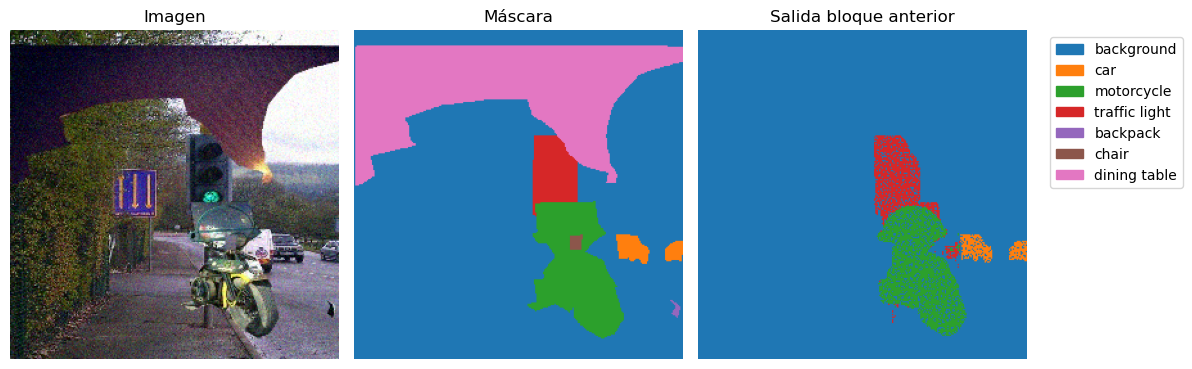

In [ ]:
def plot_image_and_mask(image, mask, salida_bloque_anterior):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}

    mask = np.argmax(mask, axis=2)
    class_ids = sorted([cid for cid in np.unique(mask)])
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Máscara")
    ax[1].axis("off")

    class_ids_anterior = sorted([cid for cid in np.unique(salida_bloque_anterior)])
    mask_colored_anterior = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids_anterior):
        mask_colored_anterior[salida_bloque_anterior==float(cid)] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[2].imshow(mask_colored_anterior)
    ax[2].set_title("Salida bloque anterior")
    ax[2].axis("off")
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_image_and_mask(img_batch[0,:,:,:3], mask_batch[0,...],img_batch[0,:,:,3])

In [14]:
objetives = yaml["objetive_classes"]
N_CLASSES = len(objetives) + 1

Se define la función de pérdida a usar, en este caso una combinada, que pondera `IoULoss` y `CategoricalCrossEntropy` para la obtención del valor de la función de pérdida. En este caso el objetivo es combinar la corrección de sesgo a clases mayoritarias de IoULoss con la facilidad de optimizar y la buena clasificación local por pixel de CEE.

In [ ]:
class IoULoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, ignore_index=0, eps=1e-6, name="iou_loss"):
        super().__init__(name=name)
        self.num_classes = num_classes

        # Atributo puesto a futuro, para estudiar si es factible ignorar el background para el cálculo de la función de pérdida
        self.ignore_index = ignore_index
        self.eps = eps

    def call(self, y_true, y_pred):

        probs = tf.clip_by_value(y_pred, self.eps, 1. - self.eps)
        ious = []

        for c in range(self.num_classes):
            if c == self.ignore_index:
                continue
            pred = probs[...,c]
            true = y_true[...,c]
            intersection= tf.reduce_sum(pred*true,axis=[1,2])
            union =tf.reduce_sum(pred+true,axis=[1,2])-intersection
            iou=(intersection+self.eps)/(union+self.eps)

            ious.append(iou)

        iou=tf.reduce_mean(tf.stack(ious,axis=0),axis=0)
        return 1. - tf.reduce_mean(iou)


class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self,alpha=0.5):
        super().__init__()
        self.alpha=alpha
        self.ce=tf.keras.losses.CategoricalCrossentropy()
        self.iou=IoULoss(num_classes=11,ignore_index=-1)

    def call(self,y_true,y_pred):
        return self.alpha*self.ce(y_true,y_pred)+(1-self.alpha)*self.iou(y_true,y_pred)

Definición del modelo:

In [ ]:

def unet_light(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Downsampling phase
    c1=layers.Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
    c1=layers.Conv2D(32,(3,3),activation='relu',padding='same')(c1)
    p1=layers.MaxPooling2D((2,2))(c1)
    c2=layers.Conv2D(64,(3,3),activation='relu',padding='same')(p1)
    c2=layers.Conv2D(64,(3,3),activation='relu',padding='same')(c2)
    p2=layers.MaxPooling2D((2,2))(c2)


    # Bottleneck
    c3=layers.Conv2D(128,(3,3),activation='relu',padding='same')(p2)
    c3=layers.Conv2D(128,(3,3),activation='relu',padding='same')(c3)


    # Upsampling phase
    u4=layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c3)
    u4=layers.concatenate([u4,c2])
    c4=layers.Conv2D(64,(3,3),activation='relu',padding='same')(u4)
    c4=layers.Conv2D(64,(3,3),activation='relu',padding='same')(c4)
    u5=layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c4)
    u5=layers.concatenate([u5,c1])
    c5=layers.Conv2D(32,(3,3),activation='relu',padding='same')(u5)
    c5=layers.Conv2D(32,(3,3),activation='relu',padding='same')(c5)

    outputs= layers.Conv2D(num_classes,(1, 1),activation='softmax')(c5)

    return models.Model(inputs=inputs, outputs=outputs)

input_shape = (256, 256, 4)
model = unet_light(input_shape=input_shape, num_classes=N_CLASSES)

Se plotea un resumen del modelo:

In [ ]:
model.summary()


Definición del optimizador:

In [ ]:
initial_learning_rate = 1e-3
optimizer = Adam(learning_rate=initial_learning_rate)

Definición de función de pérdida y callbacks usados por el modelo:

In [ ]:
model.compile(optimizer=optimizer,
              loss=CombinedLoss(alpha=0.6),
              metrics=['accuracy'])


callbacks = [
    ModelCheckpoint(r"/content/drive/MyDrive/TFM/final_unet_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    CSVLogger(r"/content/drive/MyDrive/TFM/final_unet_model_training_log.csv")
]

In [22]:
train_dataset = carga_dataset(tfrecord_path_train, batch_size=16)
test_dataset = carga_dataset(tfrecord_path_test, batch_size=16)

In [ ]:
history = model.fit(
    train_dataset.repeat(),
    steps_per_epoch=1000,
    validation_data=test_dataset.repeat(),
    validation_steps=400,
    epochs=50,
    callbacks= callbacks,
    verbose=1
)

In [ ]:
plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Accuracy en Train')
plt.plot(history.history['val_accuracy'], label='Accuracy en Validación')
plt.title('Accuracy del modelo final')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(loc='lower right')

### Visualización de los resultados



Se implementa una primera función para visualizar los resultados:

In [ ]:
def plot_image_and_mask_and_gt(image,previus_prediction, mask, gt):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}
    mask = np.argmax(mask, axis=2)
    class_ids = sorted([cid for cid in np.unique(list(np.unique(mask))+ list(np.unique(gt)))])
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    fig, ax = plt.subplots(1, 4, figsize=(14, 12))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Ground Truth")
    ax[1].axis("off")


    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    #print(patches)
    #ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    mask_gt_colored = np.zeros((gt.shape[0],gt.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_gt_colored[gt==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    ax[2].imshow(mask_gt_colored)
    ax[2].set_title("Predicción Modelo Final")
    ax[2].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    #ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')



    mask_gt_colored = np.zeros((previus_prediction.shape[0],previus_prediction.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_gt_colored[previus_prediction==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    ax[3].imshow(mask_gt_colored)
    ax[3].set_title("Predicción Bloque anterior")
    ax[3].axis("off")

    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[3].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/tmp/ipython-input-116-1937715759.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


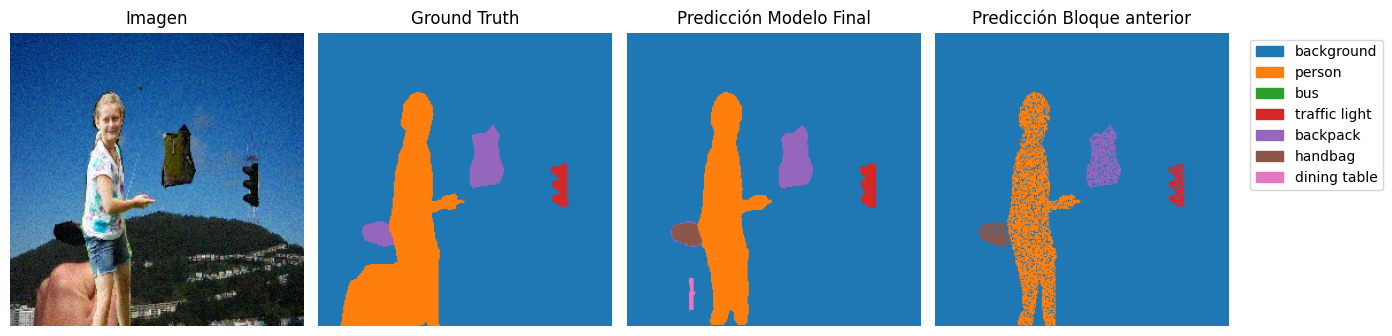

In [135]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[1,...], axis=-1)
    image = x_batch[1,:,:,:3]
    previus_prediction = x_batch[1,:,:,3]
    plot_image_and_mask_and_gt(image = image, previus_prediction = previus_prediction , mask = y_batch[1,...],gt =  final_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/tmp/ipython-input-116-1937715759.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


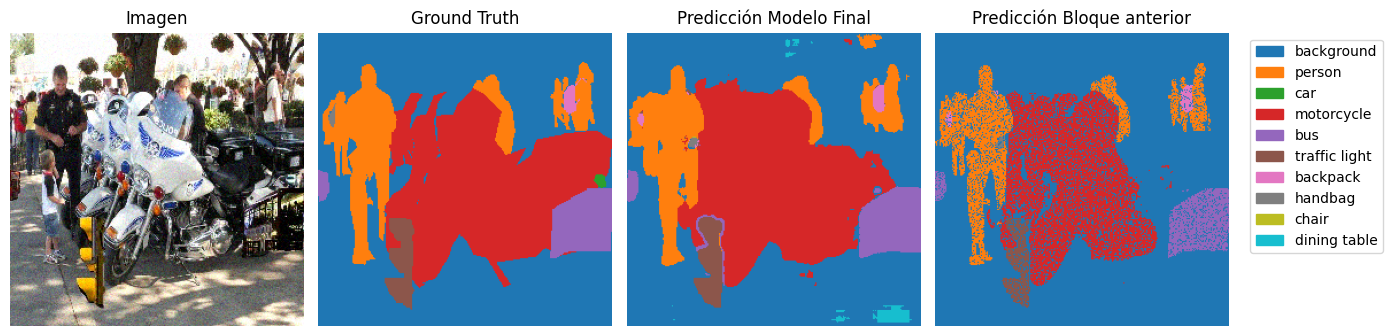

In [159]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[1,...], axis=-1)
    image = x_batch[1,:,:,:3]
    previus_prediction = x_batch[1,:,:,3]
    plot_image_and_mask_and_gt(image = image, previus_prediction = previus_prediction , mask = y_batch[1,...],gt =  final_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


/tmp/ipython-input-60-3793070104.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


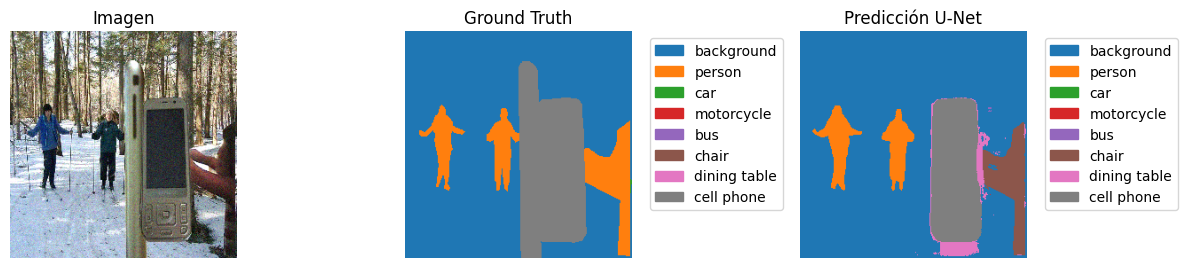

In [66]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[0,...], axis=-1)
    plot_image_and_mask_and_gt(image = x_batch[0,:,:,0:3] , mask = y_batch[0,...],gt =  final_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/tmp/ipython-input-60-3793070104.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


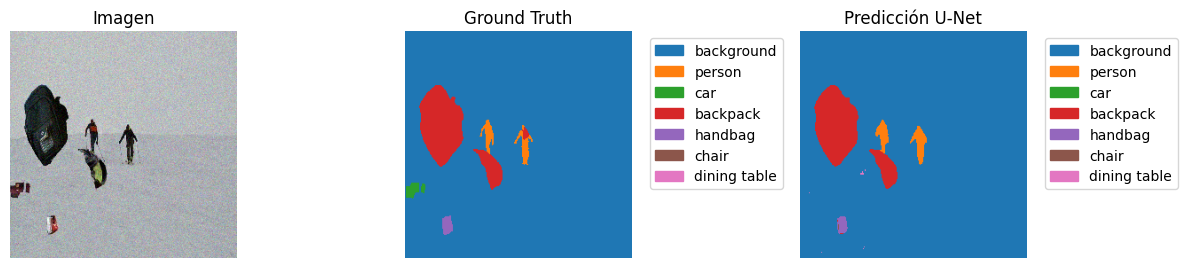

In [65]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[0,...], axis=-1)
    plot_image_and_mask_and_gt(image = x_batch[0,:,:,0:3] , mask = y_batch[0,...],gt =  final_prediction)